In [ ]:
#Provide all measures of goodnes of fit for the fitted model (confusion matrix, precision, specificity, ..., F1 score, AUC and print the ROC-curve). These measures are used to identifiy the best model in the third part below.
C. Building ‘the best’ statistical Model

#Implement a scaling approach and explain why it is necessary to scale the given variables before building a model.
Using grid search determine the optimal parameters for the imbalance and imputation approach and fit models.
Explain the steps of the modelling process, the implementation, the evaluation and the details of your preferred model.
Assess the quality of the models in detail using different measures based on the confusion matrix.
Extend your model assessment by taking into account costs for wrongly classified wafers.
Summarize your findings / best practices.

In [1]:
# import relevant libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import Lasso
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [3]:
!pip install factor_analyzer

In [4]:
!pip install --upgrade boruta

In [5]:
## define functions to be used downstream

def replace_outliers_with_3s_boundary(data):
    """
    takes a dataframe and replaces the outliers (z-score method) with 3s boundry
    also returns the fitterd standard scaler
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    z_scores = scaled_data
    outliers_positive = z_scores > 3
    outliers_negative = z_scores < -3
    scaled_data[outliers_positive] = 3
    scaled_data[outliers_negative] = -3
    data_cleaned = scaler.inverse_transform(scaled_data)
    data_cleaned = pd.DataFrame(data_cleaned, columns=data.columns)
    return data_cleaned, scaler


def boruta_feature_selection(X,y):
  """
  runs boruta feature selection technique
  returns a list of selected features
  """
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
  np.int = np.int32 # workaround for np.int deprcation
  np.float = np.float64 # likewise
  np.bool = np.bool_ # likewise
  boruta_selector.fit(X.values, y.values)
  return boruta_selector.support_
  #selected_features = X_train_cleaned_imputed.columns[boruta_selector.support_].to_list()
  #return selected_features


def KMO(X):
    kmo_all, kmo_model = calculate_kmo(X)
    print(f"KMO overall: {kmo_model}")
    if kmo_model >= 0.6:
        print("The data is suitable for PCA")
    else:
        print("The data is not suitable for PCA")
    return kmo_model


def pca_selection(X_train,X_test,variation_to_capture):
  """
  returns 2 transformed DFs (one each for X_train and X_test) with principal components to
  capture only a given
  percentage of variation
  """
  pca = PCA().fit(X_train)
  explained_variance = pca.explained_variance_ratio_
  #  create cumulative varince list
  explained_variance_cume = []
  counter = 0
  for i in explained_variance:
    explained_variance_cume.append(counter + i)
    counter = counter + i
  # get required no. of components
  num_components = len([item for item in explained_variance_cume if item <= variation_to_capture])
  print("PCA - returning {} componsnts to capture {} % variation".format(num_components,variation_to_capture*100))
  # pca to produce only the required no. of components
  pca_2 = PCA(n_components=num_components)
  pca_2.fit(X_train)
  return pd.DataFrame(pca_2.transform(X_train),columns=["PC"+str(i) for i in range(1,num_components+1)]),\
         pd.DataFrame(pca_2.transform(X_test),columns=["PC"+str(i) for i in range(1,num_components+1)])


def mice_imputer_train_test(X_train,X_test):
  mice_imputer = IterativeImputer(random_state=42)
  X_train_mice = pd.DataFrame(mice_imputer.fit_transform(X_train),columns=X_train.columns)
  X_test_mice = pd.DataFrame(mice_imputer.transform(X_test),columns=X_test.columns)
  return X_train_mice, X_test_mice

def knn_imputer_train_test(X_train,X_test):
  knn_imputer = KNNImputer(n_neighbors=5)
  X_train_knn = pd.DataFrame(knn_imputer.fit_transform(X_train),columns=X_train.columns)
  X_test_knn = pd.DataFrame(knn_imputer.transform(X_test),columns=X_test.columns)
  return X_train_knn, X_test_knn

def adasyn_oversampler(X,y):
  adasyn = ADASYN(random_state=42)
  X_adasyn, y_adasyn = adasyn.fit_resample(X,y)
  print("ADASYN Class Balancing")
  print("Class balance before- ", sorted(Counter(y).items()))
  print("Class balance after - ", sorted(Counter(y_adasyn).items()))
  return X_adasyn, y_adasyn

def smote_oversampler(X,y):
  smote = SMOTE(random_state=42)
  X_smote, y_smote = smote.fit_resample(X,y)
  print("SMOTE Class Balancing")
  print("Class balance before- ", sorted(Counter(y).items()))
  print("Class balance after - ", sorted(Counter(y_smote).items()))
  return X_smote, y_smote

def calculate_loss(cm, cost_fp, cost_fn):
    tn, fp, fn, tp = cm.ravel()
    loss_fp = fp * cost_fp
    loss_fn = fn * cost_fn
    total_loss = loss_fp + loss_fn
    return loss_fp, loss_fn, total_loss


def fit_evaluate_model(model, X_train, y_train, X_test, y_test, cost_fp, cost_fn):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    # Plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    # 计算损失
    loss_fp, loss_fn, total_loss = calculate_loss(cm, cost_fp, cost_fn)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'confusion_matrix': cm,
        'roc_auc': roc_auc_score(y_test, y_pred),
        'tpr': tpr,
        'fpr': fpr,
        'fp_loss': loss_fp,
        'fn_loss': loss_fn,
        'total_loss': total_loss
    }


def grid_search_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


def print_metrics(metrics, model_name):
    print(f"\nPerformance Metrics for {model_name}:\n")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"FP Loss: {metrics['fp_loss']:.2f}")
    print(f"FN Loss: {metrics['fn_loss']:.2f}")
    print(f"Total Loss: {metrics['total_loss']:.2f}")

In [6]:
# load data, merge, rename columns, remove timestamp
df = pd.read_csv(r'C:\Users\JingKang\Desktop\case study\secom\secom.data', delim_whitespace=True, header=None)
timestamps_df = pd.read_csv(r'C:\Users\JingKang\Desktop\case study\secom\secom_labels.data', delim_whitespace=True, header=None)
combined_df = pd.concat([timestamps_df, df], axis=1)
combined_df.columns = ['target','ts'] + [f'feature{i}' for i in range(1, df.shape[1] + 1)]
combined_df.drop(['ts'],axis=1,inplace=True) # we might not want to use date-time as a predictor

In [7]:
# train and test split
target_value = combined_df.pop("target")
X_train, X_test, y_train, y_test = train_test_split(combined_df, target_value, test_size=0.25, random_state=42, stratify=target_value)
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Number of Features:", X_train.shape[1])
print("Class balance before split- ", sorted(Counter(timestamps_df.iloc[:,0]).items()))
print("class balance after split (training)- ", sorted(Counter(y_train).items()))
print("class balance after split (test)- ", sorted(Counter(y_test).items()))
print("\nTraining set 'target value' distribution:\n", y_train.value_counts(normalize=True))
print("\nTest set 'target value' distribution:\n", y_test.value_counts(normalize=True))

Training set size: 1175
Test set size: 392
Number of Features: 590
Class balance before split-  [(-1, 1463), (1, 104)]
class balance after split (training)-  [(-1, 1097), (1, 78)]
class balance after split (test)-  [(-1, 366), (1, 26)]

Training set 'target value' distribution:
 target
-1    0.933617
 1    0.066383
Name: proportion, dtype: float64

Test set 'target value' distribution:
 target
-1    0.933673
 1    0.066327
Name: proportion, dtype: float64


In [8]:
# drop features with no variances
variances_in_train_set = X_train.var()
X_train = X_train.loc[:, variances_in_train_set != 0]

#if using the same method to clean the no variance feature in x test set, the result is different from that of x train
X_test = X_test[X_train.columns]
print("Number of Features:", X_train.shape[1])

Number of Features: 474


In [9]:
# drop features with missing value ratio larger than 55%
missing_value_ratio = X_train.isna().mean()
columns_to_keep = missing_value_ratio[missing_value_ratio < 0.55].index
X_train = X_train[columns_to_keep]
X_test = X_test[X_train.columns]
print("Number of Features remaining after removing features with missing over 55%:", X_train.shape[1])

Number of Features remaining after removing features with missing over 55%: 450


In [10]:
X_train_3s, fitted_scaler = replace_outliers_with_3s_boundary(X_train)
# X_test_3s = replace_outliers_with_3s_boundary(X_test) # tbd to be corrected later

# use the fitted scale to treat outliers in testing dataset
z_scores = fitted_scaler.transform(X_test)
outliers_positive = z_scores > 3
outliers_negative = z_scores < -3
z_scores[outliers_positive] = 3
z_scores[outliers_negative] = -3
X_test_3s = fitted_scaler.inverse_transform(z_scores)
X_test_3s = pd.DataFrame(X_test_3s, columns=X_test.columns)

### Trying different imputation techniques and comparing them. Since some of the techniques like Knn are distance based, we have to scale the data. We add noise to the data (Random NAs) to be able to compare different imputation methods.

In [11]:
# Scale the data to range 0,1, since some of the methods that we might use downstream are distance based
mm_scaler = MinMaxScaler()
X_train_3s_MM_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train_3s),columns=X_train_3s.columns)
X_test_3s_MM_scaled = pd.DataFrame(mm_scaler.transform(X_test_3s), columns=X_test_3s.columns)

In [12]:
X_train_selected = X_train_3s_MM_scaled
X_test_selected = X_test_3s_MM_scaled

In [13]:
# We will try below techniques
# Imputation - KNN, MICE
# Class imbalance - ADASYN, SMOTE
# Feature Selection / Reduction - Boruta, PCA, Factor
# Baseline classfier with Random Forest method

model_results_list=[]

In [14]:
# A a six-inch wafer can costs under $10.00/wafer to well over $100.00 per wafer
cost_fp = 50  # 50 EURO
cost_fn = 100  # 100 EURO

In [15]:
### Combination - "kNN Imputation"-"BORUTA selection"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1083)]


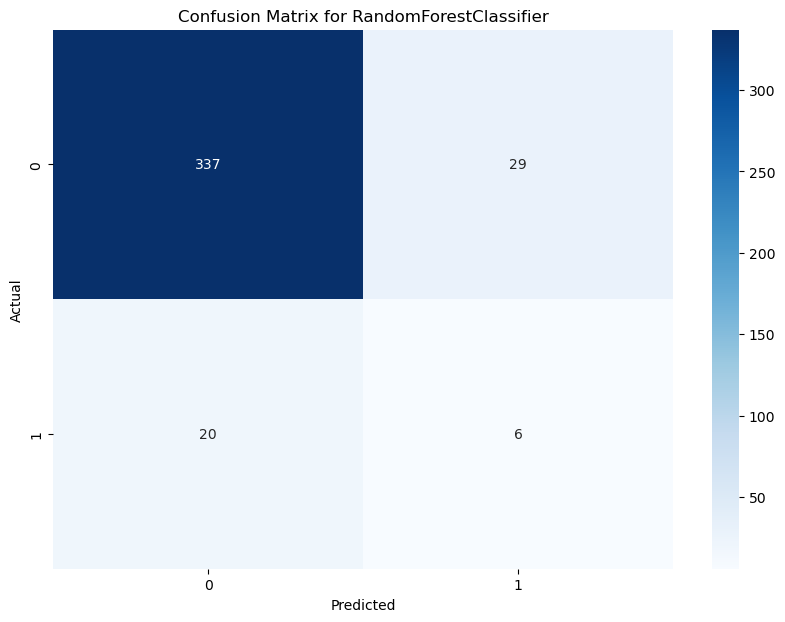


Performance Metrics for Random Forest:

Accuracy: 0.8750
Precision: 0.1714
Recall: 0.2308
F1 Score: 0.1967
ROC AUC Score: 0.5758
Confusion Matrix:
[[337  29]
 [ 20   6]]
FP Loss: 1450.00
FN Loss: 2000.00
Total Loss: 3450.00
Fitting 5 folds for each of 81 candidates, totalling 405 fits


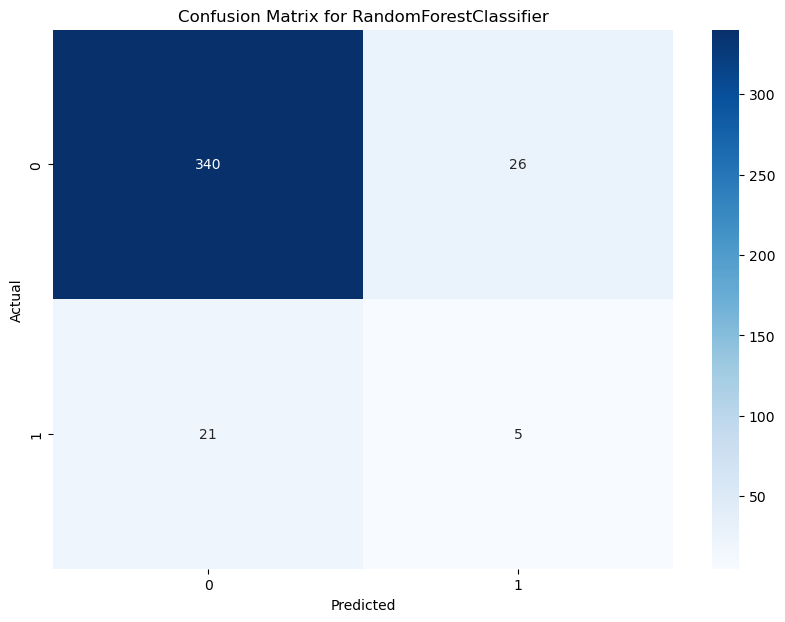


Performance Metrics for Random Forest (Optimized):

Accuracy: 0.8801
Precision: 0.1613
Recall: 0.1923
F1 Score: 0.1754
ROC AUC Score: 0.5606
Confusion Matrix:
[[340  26]
 [ 21   5]]
FP Loss: 1300.00
FN Loss: 2100.00
Total Loss: 3400.00


In [15]:
#combination 01-Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_metrics = fit_evaluate_model(rf_model, X_train_03, y_train_03, X_test_03, y_test_03,cost_fp, cost_fn)
print_metrics(rf_metrics, "Random Forest")

# random forest model
model_results_list.append({
    'Model name': 'RandomForest',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'RandomForest classifier',
    'Accuracy': rf_metrics['accuracy'],
    'Precision': rf_metrics['precision'],
    'Recall': rf_metrics['recall'],
    'F1': rf_metrics['f1_score'],
    'Confusion Matrix': rf_metrics['confusion_matrix'].tolist(),
    'ROC AUC': rf_metrics['roc_auc'],
    'FP Loss': rf_metrics['fp_loss'],
    'FN Loss': rf_metrics['fn_loss'],
    'Total Loss': rf_metrics['total_loss']
})


# use Grid Search to find the optimal parameter Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_rf_model = grid_search_model(RandomForestClassifier(random_state=42), rf_param_grid, X_train_03, y_train_03)

# optimized Random Forest model
optimized_rf_metrics = fit_evaluate_model(best_rf_model, X_train_03, y_train_03, X_test_03, y_test_03,cost_fp, cost_fn)
print_metrics(optimized_rf_metrics, "Random Forest (Optimized)")

baseline_loss_fp, baseline_loss_fn, baseline_total_loss = calculate_loss(rf_metrics['confusion_matrix'], cost_fp, cost_fn)
optimized_loss_fp, optimized_loss_fn, optimized_total_loss = calculate_loss(optimized_rf_metrics['confusion_matrix'], cost_fp, cost_fn)

model_results_list.append({
    'Model name': 'RandomForest',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'optimized RandomForest classifier',
    'Accuracy': optimized_rf_metrics['accuracy'],
    'Precision': optimized_rf_metrics['precision'],
    'Recall': optimized_rf_metrics['recall'],
    'F1': optimized_rf_metrics['f1_score'],
    'Confusion Matrix': optimized_rf_metrics['confusion_matrix'].tolist(),
    'ROC AUC': optimized_rf_metrics['roc_auc'],
    'FP Loss': optimized_rf_metrics['fp_loss'],
    'FN Loss': optimized_rf_metrics['fn_loss'],
    'Total Loss': optimized_rf_metrics['total_loss']
})



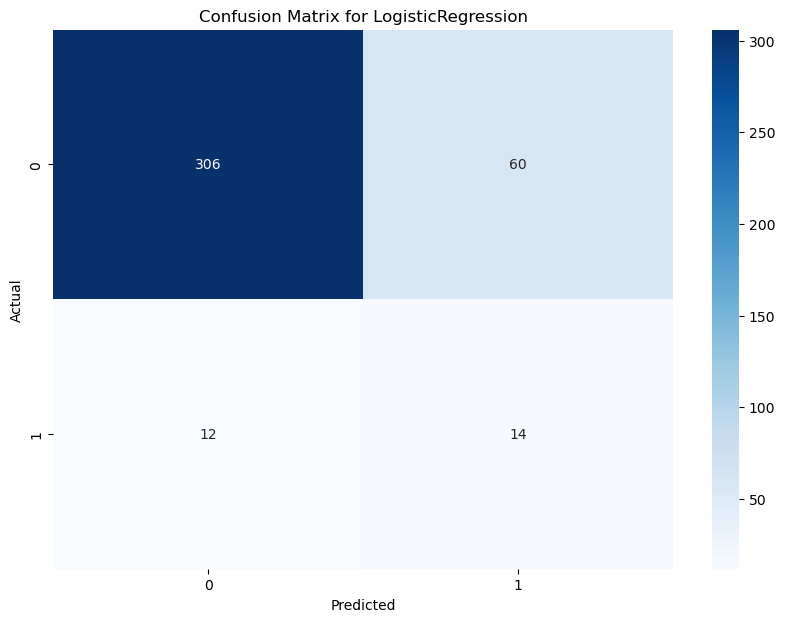


Performance Metrics for Logistic Regression:

Accuracy: 0.8163
Precision: 0.1892
Recall: 0.5385
F1 Score: 0.2800
ROC AUC Score: 0.6873
Confusion Matrix:
[[306  60]
 [ 12  14]]
FP Loss: 3000.00
FN Loss: 1200.00
Total Loss: 4200.00
Fitting 5 folds for each of 8 candidates, totalling 40 fits


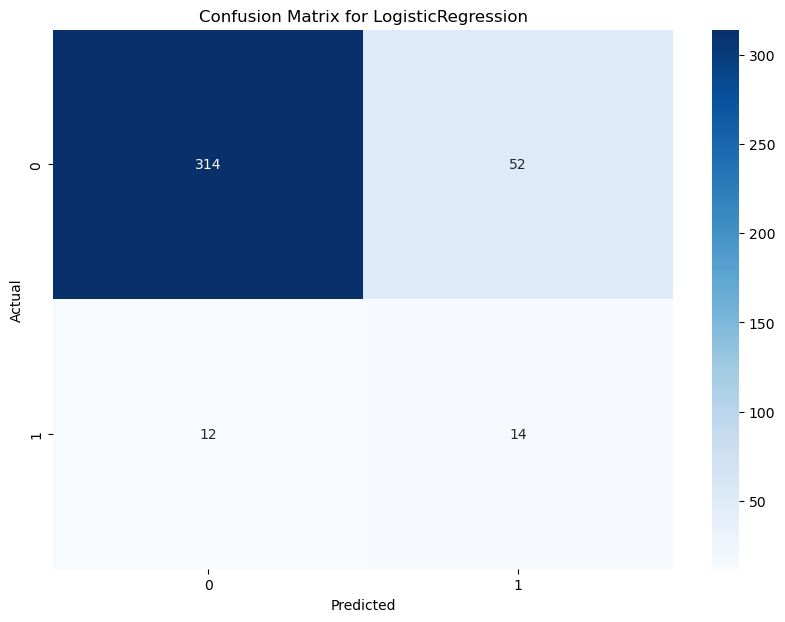


Performance Metrics for Logistic Regression (Optimized):

Accuracy: 0.8367
Precision: 0.2121
Recall: 0.5385
F1 Score: 0.3043
ROC AUC Score: 0.6982
Confusion Matrix:
[[314  52]
 [ 12  14]]
FP Loss: 2600.00
FN Loss: 1200.00
Total Loss: 3800.00


In [16]:
#combination 01-Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_metrics = fit_evaluate_model(lr_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(lr_metrics, "Logistic Regression")

model_results_list.append({
    'Model name': 'Logistic Regression',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'Logistic Regression classifier',
    'Accuracy': lr_metrics['accuracy'],
    'Precision': lr_metrics['precision'],
    'Recall': lr_metrics['recall'],
    'F1': lr_metrics['f1_score'],
    'Confusion Matrix': lr_metrics['confusion_matrix'].tolist(),
    'ROC AUC': lr_metrics['roc_auc'],
    'FP Loss': lr_metrics['fp_loss'],
    'FN Loss': lr_metrics['fn_loss'],
    'Total Loss': lr_metrics['total_loss']
})


#use grid search to find the optimal parameter
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_03, y_train_03)
best_lr_model = grid_search.best_estimator_

# 训练和评估优化后的模型
optimized_lr_metrics = fit_evaluate_model(best_lr_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(optimized_lr_metrics, "Logistic Regression (Optimized)")

# 将优化后的结果添加到结果列表
model_results_list.append({
    'Model name': 'Logistic Regression',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'optimized Logistic Regression classifier',
    'Accuracy': optimized_lr_metrics['accuracy'],
    'Precision': optimized_lr_metrics['precision'],
    'Recall': optimized_lr_metrics['recall'],
    'F1': optimized_lr_metrics['f1_score'],
    'Confusion Matrix': optimized_lr_metrics['confusion_matrix'].tolist(),
    'ROC AUC': optimized_lr_metrics['roc_auc'],
    'FP Loss': optimized_lr_metrics['fp_loss'],
    'FN Loss': optimized_lr_metrics['fn_loss'],
    'Total Loss': optimized_lr_metrics['total_loss']
})


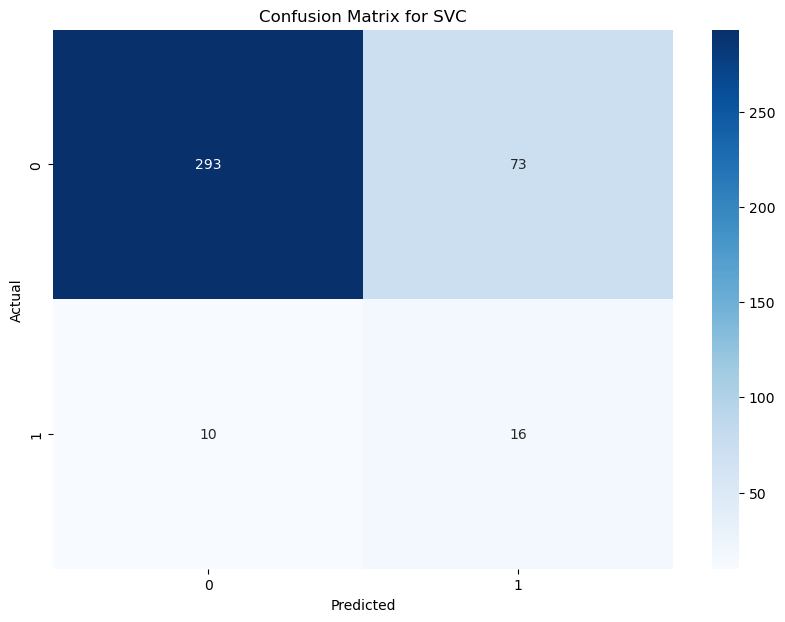


Performance Metrics for SVM (Baseline):

Accuracy: 0.7883
Precision: 0.1798
Recall: 0.6154
F1 Score: 0.2783
ROC AUC Score: 0.7080
Confusion Matrix:
[[293  73]
 [ 10  16]]
FP Loss: 3650.00
FN Loss: 1000.00
Total Loss: 4650.00
Fitting 5 folds for each of 16 candidates, totalling 80 fits


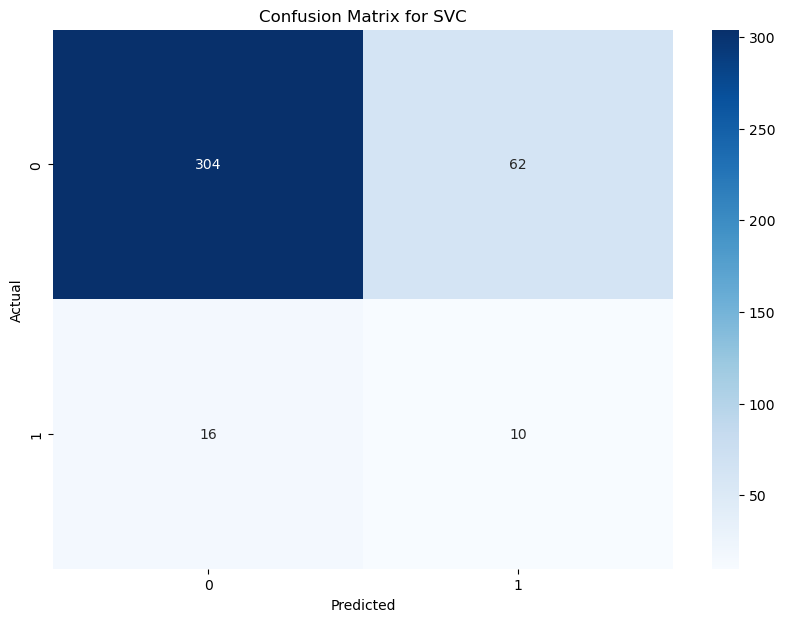


Performance Metrics for SVM (Optimized):

Accuracy: 0.8010
Precision: 0.1389
Recall: 0.3846
F1 Score: 0.2041
ROC AUC Score: 0.6076
Confusion Matrix:
[[304  62]
 [ 16  10]]
FP Loss: 3100.00
FN Loss: 1600.00
Total Loss: 4700.00


In [17]:
#combination 01-SVM
svm_model = SVC(random_state=42)
svm_metrics = fit_evaluate_model(svm_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(svm_metrics, "SVM (Baseline)")

# 将结果添加到结果列表
model_results_list.append({
    'Model name': 'SVM',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'baseline SVM classifier',
    'Accuracy': svm_metrics['accuracy'],
    'Precision': svm_metrics['precision'],
    'Recall': svm_metrics['recall'],
    'F1': svm_metrics['f1_score'],
    'Confusion Matrix': svm_metrics['confusion_matrix'].tolist(),
    'ROC AUC': svm_metrics['roc_auc'],
    'FP Loss': svm_metrics['fp_loss'],
    'FN Loss': svm_metrics['fn_loss'],
    'Total Loss': svm_metrics['total_loss']
})

# 使用Grid Search优化SVM模型
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_03, y_train_03)
best_svm_model = grid_search.best_estimator_

# 训练和评估优化后的模型
optimized_svm_metrics = fit_evaluate_model(best_svm_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(optimized_svm_metrics, "SVM (Optimized)")

# 将优化后的结果添加到结果列表
model_results_list.append({
    'Model name': 'SVM',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'optimized SVM classifier',
    'Accuracy': optimized_svm_metrics['accuracy'],
    'Precision': optimized_svm_metrics['precision'],
    'Recall': optimized_svm_metrics['recall'],
    'F1': optimized_svm_metrics['f1_score'],
    'Confusion Matrix': optimized_svm_metrics['confusion_matrix'].tolist(),
    'ROC AUC': optimized_svm_metrics['roc_auc'],
    'FP Loss': optimized_svm_metrics['fp_loss'],
    'FN Loss': optimized_svm_metrics['fn_loss'],
    'Total Loss': optimized_svm_metrics['total_loss']
})


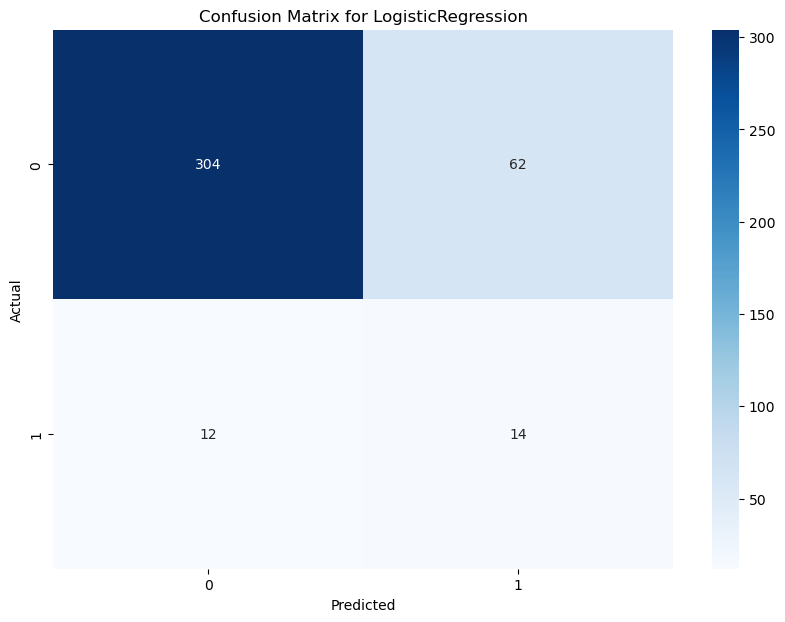


Performance Metrics for Logistic Regression with K-means:

Accuracy: 0.8112
Precision: 0.1842
Recall: 0.5385
F1 Score: 0.2745
ROC AUC Score: 0.6845
Confusion Matrix:
[[304  62]
 [ 12  14]]
FP Loss: 3100.00
FN Loss: 1200.00
Total Loss: 4300.00


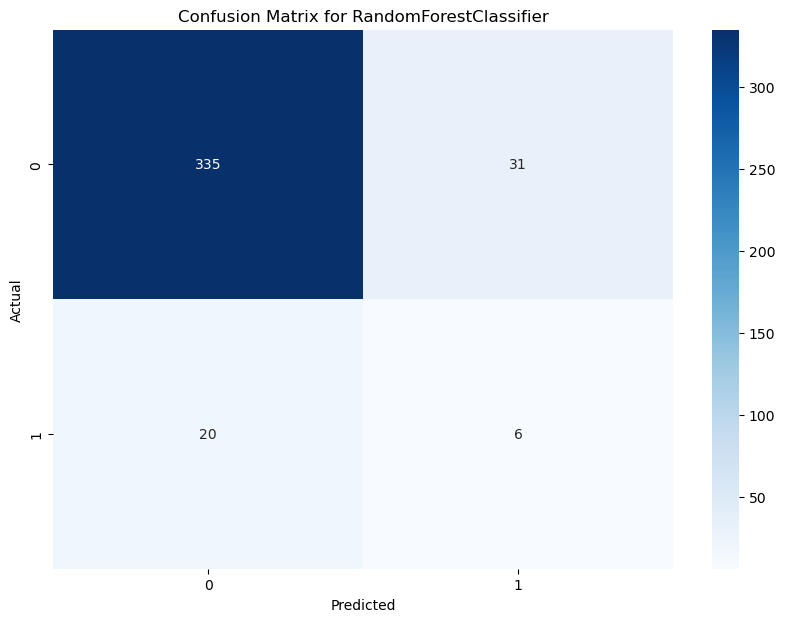


Performance Metrics for Random Forest with K-means:

Accuracy: 0.8699
Precision: 0.1622
Recall: 0.2308
F1 Score: 0.1905
ROC AUC Score: 0.5730
Confusion Matrix:
[[335  31]
 [ 20   6]]
FP Loss: 1550.00
FN Loss: 2000.00
Total Loss: 3550.00


In [18]:
#combination 01-Cluster Analysis
# 运行K-means聚类
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_03_kmeans = kmeans.fit_predict(X_train_03).reshape(-1, 1)
X_test_03_kmeans = kmeans.predict(X_test_03).reshape(-1, 1)

# 将聚类结果作为新特征添加到原始特征中
X_train_03_extended = np.hstack((X_train_03, X_train_03_kmeans))
X_test_03_extended = np.hstack((X_test_03, X_test_03_kmeans))

# 训练和评估Logistic Regression模型
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_metrics = fit_evaluate_model(lr_model, X_train_03_extended, y_train_03, X_test_03_extended, y_test_03, cost_fp, cost_fn)
print_metrics(lr_metrics, "Logistic Regression with K-means")

# 将结果添加到结果列表
model_results_list.append({
    'Model name': 'Logistic Regression with K-means',
    'Technique': 'baseline Logistic Regression classifier',
    'Accuracy': lr_metrics['accuracy'],
    'Precision': lr_metrics['precision'],
    'Recall': lr_metrics['recall'],
    'F1': lr_metrics['f1_score'],
    'Confusion Matrix': lr_metrics['confusion_matrix'].tolist(),
    'ROC AUC': lr_metrics['roc_auc'],
    'FP Loss': lr_metrics['fp_loss'],
    'FN Loss': lr_metrics['fn_loss'],
    'Total Loss': lr_metrics['total_loss']
})

# 训练和评估Random Forest模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_metrics = fit_evaluate_model(rf_model, X_train_03_extended, y_train_03, X_test_03_extended, y_test_03, cost_fp, cost_fn)
print_metrics(rf_metrics, "Random Forest with K-means")

# 将结果添加到结果列表
model_results_list.append({
    'Model name': 'Random Forest with K-means',
    'Technique': 'baseline Random Forest classifier',
    'Accuracy': rf_metrics['accuracy'],
    'Precision': rf_metrics['precision'],
    'Recall': rf_metrics['recall'],
    'F1': rf_metrics['f1_score'],
    'Confusion Matrix': rf_metrics['confusion_matrix'].tolist(),
    'ROC AUC': rf_metrics['roc_auc'],
    'FP Loss': rf_metrics['fp_loss'],
    'FN Loss': rf_metrics['fn_loss'],
    'Total Loss': rf_metrics['total_loss']
})

# 将结果转换为DataFrame并保存为Excel文件
results_df = pd.DataFrame(model_results_list)
results_df.to_excel('model_results_with_kmeans.xlsx', index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
最佳簇数: 2


C:\Users\JingKang\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


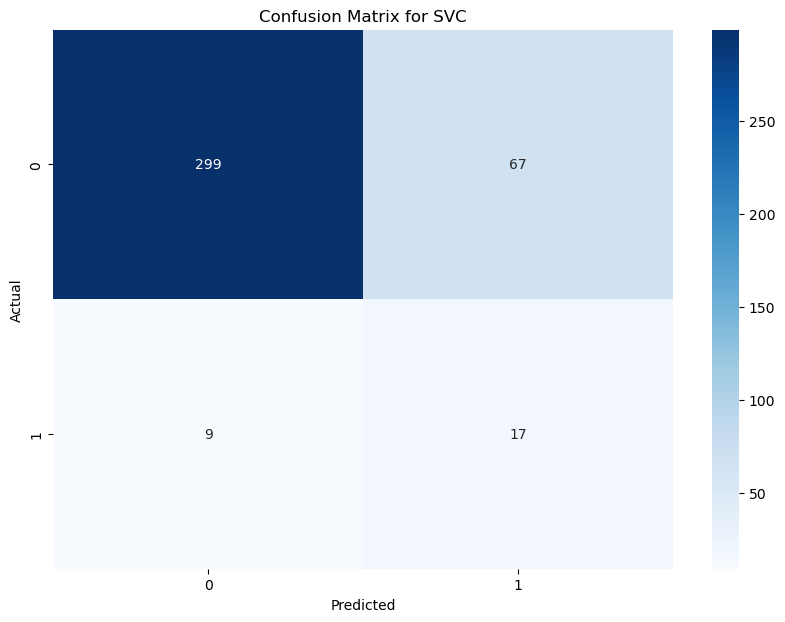


Performance Metrics for SVM (Baseline):

Accuracy: 0.8061
Precision: 0.2024
Recall: 0.6538
F1 Score: 0.3091
ROC AUC Score: 0.7354
Confusion Matrix:
[[299  67]
 [  9  17]]
FP Loss: 3350.00
FN Loss: 900.00
Total Loss: 4250.00


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin

class KMeansClusterer(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def predict(self, X):
        return self.kmeans.predict(X)
    
    def fit_predict(self, X, y=None):
        return self.kmeans.fit_predict(X)
    
    def score(self, X, y=None):
        labels = self.kmeans.fit_predict(X)
        return silhouette_score(X, labels)

# 数据准备
X_train = X_train_03  # 你的训练数据

# 定义参数网格
param_grid = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

# 自定义评分函数
silhouette_scorer = make_scorer(silhouette_score)

# 使用GridSearchCV进行参数调优
grid_search = GridSearchCV(estimator=KMeansClusterer(), param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1, verbose=2)
grid_search.fit(X_train)

# 最佳簇数
best_n_clusters = grid_search.best_params_['n_clusters']
print(f"最佳簇数: {best_n_clusters}")

# 使用最佳簇数进行聚类
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
X_train_03_kmeans = best_kmeans.fit_predict(X_train_03).reshape(-1, 1)
X_test_03_kmeans = best_kmeans.predict(X_test_03).reshape(-1, 1)

# 将聚类结果作为新特征添加到原始特征中
X_train_03_extended = np.hstack((X_train_03, X_train_03_kmeans))
X_test_03_extended = np.hstack((X_test_03, X_test_03_kmeans))

# 定义SVM模型并评估
svm_model = SVC(random_state=42)
svm_metrics = fit_evaluate_model(svm_model, X_train_03_extended, y_train_03, X_test_03_extended, y_test_03, cost_fp, cost_fn)
print_metrics(svm_metrics, "SVM (Baseline)")

# 将结果添加到结果列表
model_results_list.append({
    'Model name': 'SVM',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'SVM with K-means',
    'Accuracy': svm_metrics['accuracy'],
    'Precision': svm_metrics['precision'],
    'Recall': svm_metrics['recall'],
    'F1': svm_metrics['f1_score'],
    'Confusion Matrix': svm_metrics['confusion_matrix'].tolist(),
    'ROC AUC': svm_metrics['roc_auc'],
    'FP Loss': svm_metrics['fp_loss'],
    'FN Loss': svm_metrics['fn_loss'],
    'Total Loss': svm_metrics['total_loss']
})

# 将结果转换为DataFrame并保存为Excel文件
results_df = pd.DataFrame(model_results_list)
results_df.to_excel('model_results_with_kmeans_svm.xlsx', index=False)

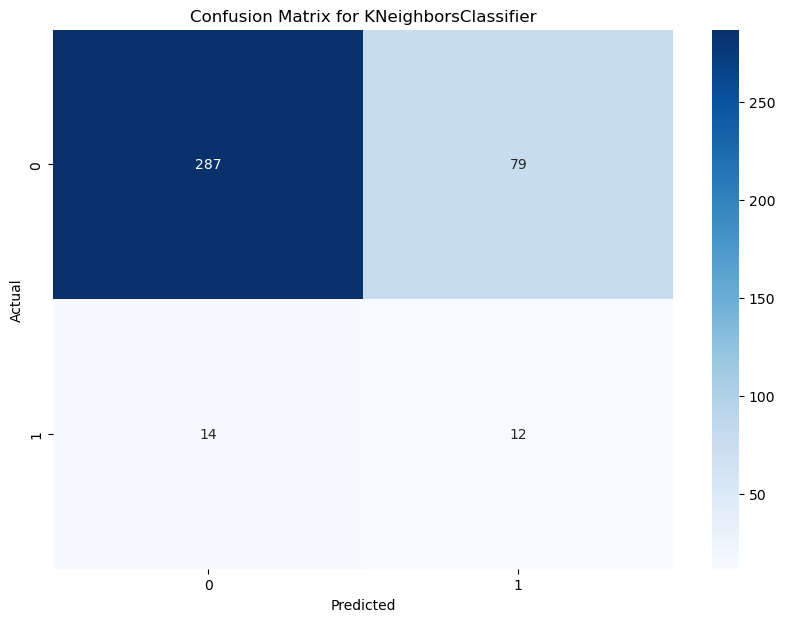


Performance Metrics for kNN (Baseline):

Accuracy: 0.7628
Precision: 0.1319
Recall: 0.4615
F1 Score: 0.2051
ROC AUC Score: 0.6228
Confusion Matrix:
[[287  79]
 [ 14  12]]
FP Loss: 3950.00
FN Loss: 1400.00
Total Loss: 5350.00
Fitting 5 folds for each of 16 candidates, totalling 80 fits


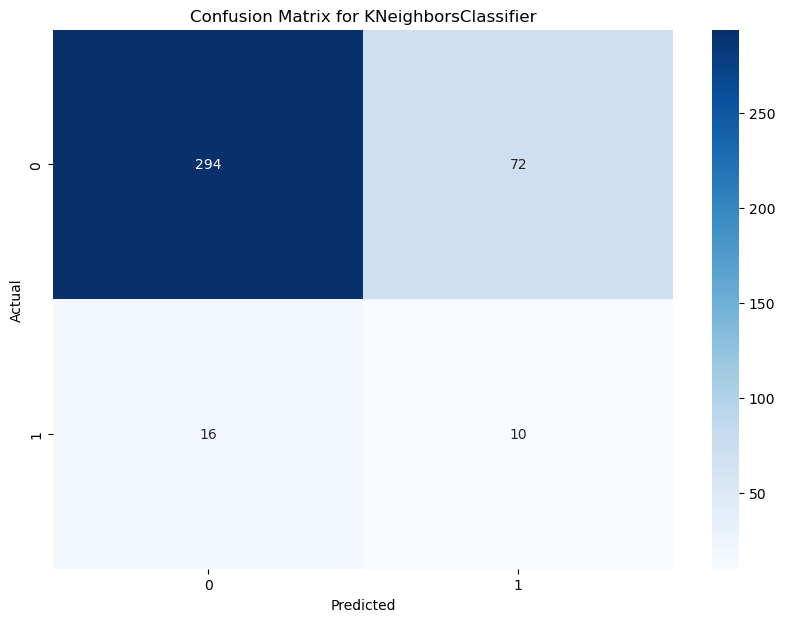


Performance Metrics for kNN (Optimized):

Accuracy: 0.7755
Precision: 0.1220
Recall: 0.3846
F1 Score: 0.1852
ROC AUC Score: 0.5939
Confusion Matrix:
[[294  72]
 [ 16  10]]
FP Loss: 3600.00
FN Loss: 1600.00
Total Loss: 5200.00


In [20]:
# 定义kNN模型并评估
knn_model = KNeighborsClassifier()
knn_metrics = fit_evaluate_model(knn_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(knn_metrics, "kNN (Baseline)")

# 将结果添加到结果列表
model_results_list.append({
    'Model name': 'kNN',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'baseline kNN classifier',
    'Accuracy': knn_metrics['accuracy'],
    'Precision': knn_metrics['precision'],
    'Recall': knn_metrics['recall'],
    'F1': knn_metrics['f1_score'],
    'Confusion Matrix': knn_metrics['confusion_matrix'].tolist(),
    'ROC AUC': knn_metrics['roc_auc'],
    'FP Loss': knn_metrics['fp_loss'],
    'FN Loss': knn_metrics['fn_loss'],
    'Total Loss': knn_metrics['total_loss']
})

# 使用Grid Search优化kNN模型
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_03, y_train_03)
best_knn_model = grid_search.best_estimator_

# 训练和评估优化后的模型
optimized_knn_metrics = fit_evaluate_model(best_knn_model, X_train_03, y_train_03, X_test_03, y_test_03, cost_fp, cost_fn)
print_metrics(optimized_knn_metrics, "kNN (Optimized)")

# 将优化后的结果添加到结果列表
model_results_list.append({
    'Model name': 'kNN',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'optimized kNN classifier',
    'Accuracy': optimized_knn_metrics['accuracy'],
    'Precision': optimized_knn_metrics['precision'],
    'Recall': optimized_knn_metrics['recall'],
    'F1': optimized_knn_metrics['f1_score'],
    'Confusion Matrix': optimized_knn_metrics['confusion_matrix'].tolist(),
    'ROC AUC': optimized_knn_metrics['roc_auc'],
    'FP Loss': optimized_knn_metrics['fp_loss'],
    'FN Loss': optimized_knn_metrics['fn_loss'],
    'Total Loss': optimized_knn_metrics['total_loss']
})

results_df = pd.DataFrame(model_results_list)
results_df.to_excel('results for combination 1.xlsx', index=False)

In [ ]:
#Combination 2 - "kNN Imputation"-"PCA reduction"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# check data adequacy for PCA
kmo_model = KMO(X_train_01)


# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01


# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02


C:\Users\JingKang\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO overall: 0.6842975387008048
The data is suitable for PCA


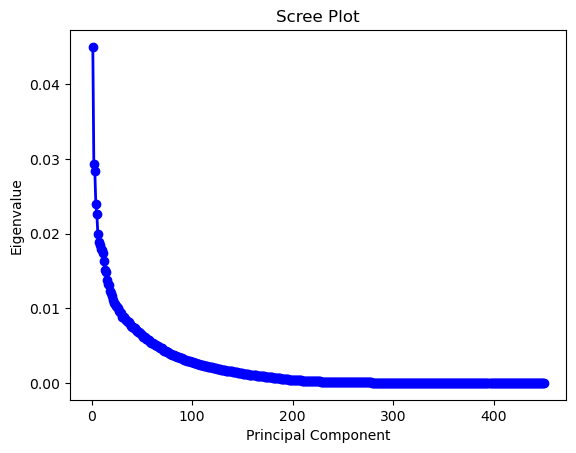

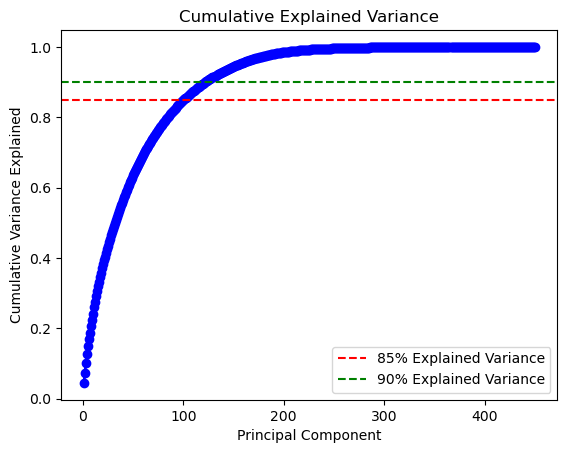

PCA - returning 61 componsnts to capture 70.0 % variation
ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1128)]


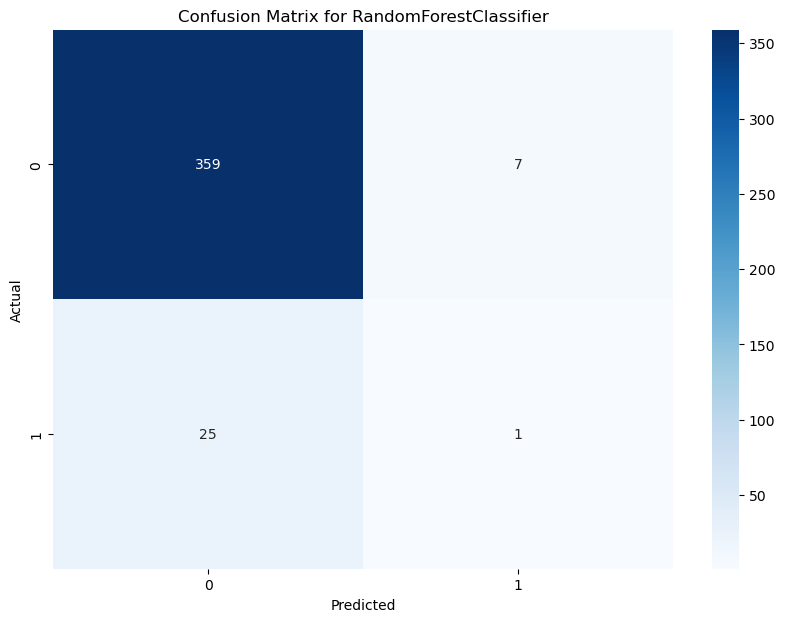


Performance Metrics for Random Forest (Baseline):

Accuracy: 0.9184
Precision: 0.1250
Recall: 0.0385
F1 Score: 0.0588
ROC AUC Score: 0.5097
Confusion Matrix:
[[359   7]
 [ 25   1]]
FP Loss: 350.00
FN Loss: 2500.00
Total Loss: 2850.00
Fitting 5 folds for each of 81 candidates, totalling 405 fits


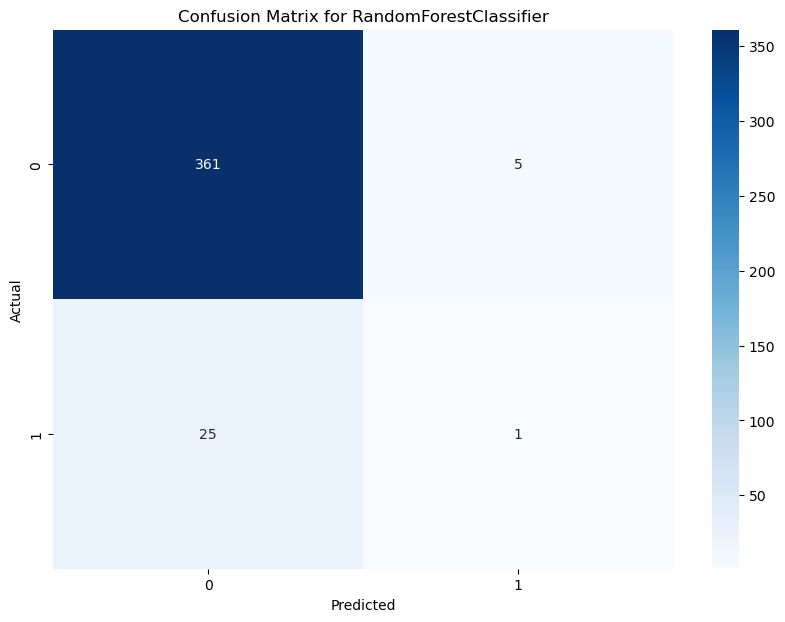


Performance Metrics for Random Forest (Optimized):

Accuracy: 0.9235
Precision: 0.1667
Recall: 0.0385
F1 Score: 0.0625
ROC AUC Score: 0.5124
Confusion Matrix:
[[361   5]
 [ 25   1]]
FP Loss: 250.00
FN Loss: 2500.00
Total Loss: 2750.00


In [43]:


rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_metrics = fit_evaluate_model(rf_model, X_train_03, y_train_03, X_test_03, y_test_03,cost_fp, cost_fn)
print_metrics(rf_metrics, "Random Forest (Baseline)")

# random forest model

model_results_list.append({
    'Model 02': 'RandomForest',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'baseline RandomForest classifier',
    'Accuracy': rf_metrics['accuracy'],
    'Precision': rf_metrics['precision'],
    'Recall': rf_metrics['recall'],
    'F1': rf_metrics['f1_score'],
    'Confusion Matrix': rf_metrics['confusion_matrix'].tolist(),
    'ROC AUC': rf_metrics['roc_auc'],
    'FP Loss': rf_metrics['fp_loss'],
    'FN Loss': rf_metrics['fn_loss'],
    'Total Loss': rf_metrics['total_loss']
})


rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 使用Grid Search寻找最佳Random Forest模型
best_rf_model = grid_search_model(RandomForestClassifier(random_state=42), rf_param_grid, X_train_03, y_train_03)

# 训练和评估优化后的Random Forest模型
optimized_rf_metrics = fit_evaluate_model(best_rf_model, X_train_03, y_train_03, X_test_03, y_test_03,cost_fp, cost_fn)
print_metrics(optimized_rf_metrics, "Random Forest (Optimized)")

baseline_loss_fp, baseline_loss_fn, baseline_total_loss = calculate_loss(rf_metrics['confusion_matrix'], cost_fp, cost_fn)
optimized_loss_fp, optimized_loss_fn, optimized_total_loss = calculate_loss(optimized_rf_metrics['confusion_matrix'], cost_fp, cost_fn)

model_results_list.append({
    'Model 02-1': 'RandomForest',
    'CRISP DM Decisions': '(KNN Imputation, ADASYN balancing, BORUTA selection)',
    'Technique': 'baseline RandomForest classifier',
    'Accuracy': rf_metrics['accuracy'],
    'Precision': rf_metrics['precision'],
    'Recall': rf_metrics['recall'],
    'F1': rf_metrics['f1_score'],
    'Confusion Matrix': rf_metrics['confusion_matrix'].tolist(),
    'ROC AUC': rf_metrics['roc_auc'],
    'FP Loss': rf_metrics['fp_loss'],
    'FN Loss': rf_metrics['fn_loss'],
    'Total Loss': rf_metrics['total_loss']
})


In [60]:
### Model 3 - "KNN Imputation"-"BORUTA selection"-"SMOTE balancing", 
## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_03",
                 ("KNN Imputation", "SMOTE balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_03', ('KNN Imputation', 'SMOTE balancing', 'BORUTA selection'), 'baseline RF classifier', 0.8928571428571429, 0.25, 0.3076923076923077, 0.27586206896551724, array([[342,  24],
       [ 18,   8]], dtype=int64), 0.6210592686002522, array([0.        , 0.06557377, 1.        ]), array([0.        , 0.30769231, 1.        ]))


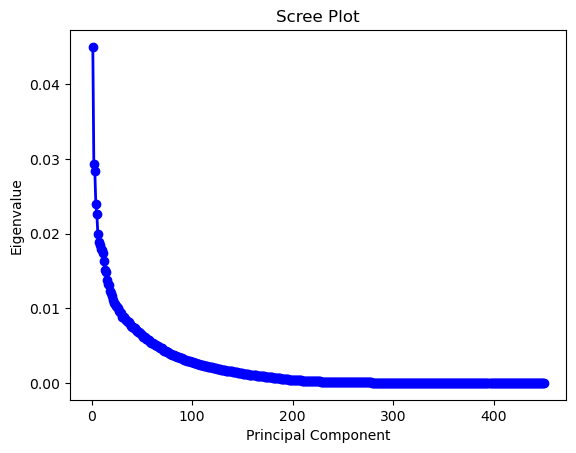

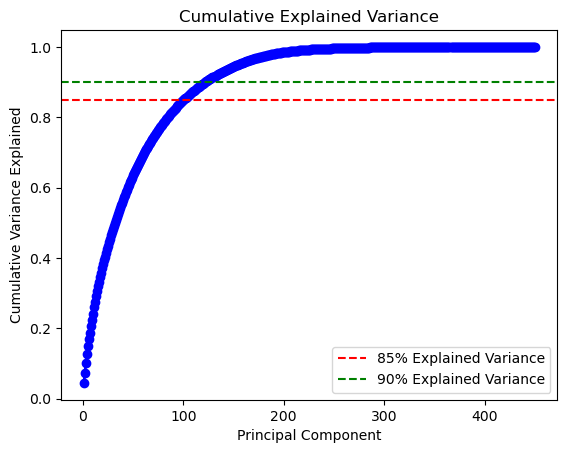

PCA - returning 61 componsnts to capture 70.0 % variation
SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_04', ('KNN Imputation', 'SMOTE balancing', 'PCA selection'), 'baseline RF classifier', 0.9132653061224489, 0.16666666666666666, 0.07692307692307693, 0.10526315789473684, array([[356,  10],
       [ 24,   2]], dtype=int64), 0.5248003362757461, array([0.       , 0.0273224, 1.       ]), array([0.        , 0.07692308, 1.        ]))


In [63]:
### Model 4 - "KNN Imputation"-"PCA selection"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test


# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_04",
                 ("KNN Imputation", "SMOTE balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [64]:
### Model 5 - "MICE Imputation"-"BORUTA selection"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_05",
                 ("MICE Imputation", "ADASYN balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

C:\Users\JingKang\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1068)]
('model_05', ('MICE Imputation', 'ADASYN balancing', 'BORUTA selection'), 'baseline RF classifier', 0.8775510204081632, 0.13333333333333333, 0.15384615384615385, 0.14285714285714285, array([[340,  26],
       [ 22,   4]], dtype=int64), 0.5414039512400168, array([0.        , 0.07103825, 1.        ]), array([0.        , 0.15384615, 1.        ]))


In [65]:
boruta_features

['feature60',
 'feature65',
 'feature66',
 'feature104',
 'feature427',
 'feature442',
 'feature563',
 'feature575']

C:\Users\JingKang\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO overall: 0.6726012527541437
The data is suitable for PCA


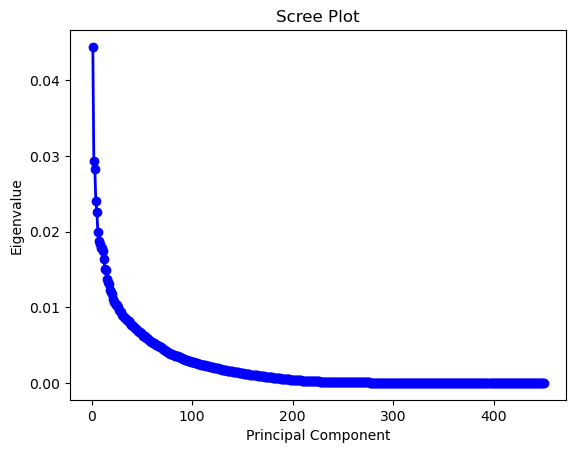

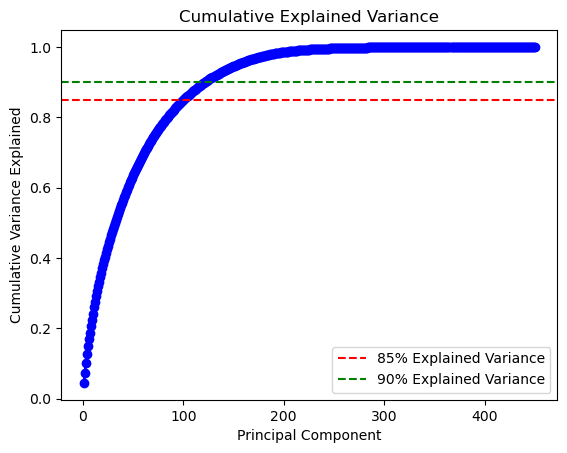

PCA - returning 61 componsnts to capture 70.0 % variation
ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1088)]
('model_06', ('MICE Imputation', 'ADASYN balancing', 'PCA selection'), 'baseline RF classifier', 0.9107142857142857, 0.15384615384615385, 0.07692307692307693, 0.10256410256410256, array([[355,  11],
       [ 24,   2]], dtype=int64), 0.5234342160571669, array([0.        , 0.03005464, 1.        ]), array([0.        , 0.07692308, 1.        ]))


In [66]:
### Model 6 - "MICE Imputation"-"PCA reduction"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test


# check data adequacy for PCA
kmo_model = KMO(X_train_01)

# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_06",
                 ("MICE Imputation", "ADASYN balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [67]:
### Model 7 - "MICE Imputation"-"BORUTA reduction"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_07",
                 ("MICE Imputation", "SMOTE balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_07', ('MICE Imputation', 'SMOTE balancing', 'BORUTA selection'), 'baseline RF classifier', 0.9005102040816326, 0.21739130434782608, 0.19230769230769232, 0.20408163265306123, array([[348,  18],
       [ 21,   5]], dtype=int64), 0.5715636822194199, array([0.        , 0.04918033, 1.        ]), array([0.        , 0.19230769, 1.        ]))


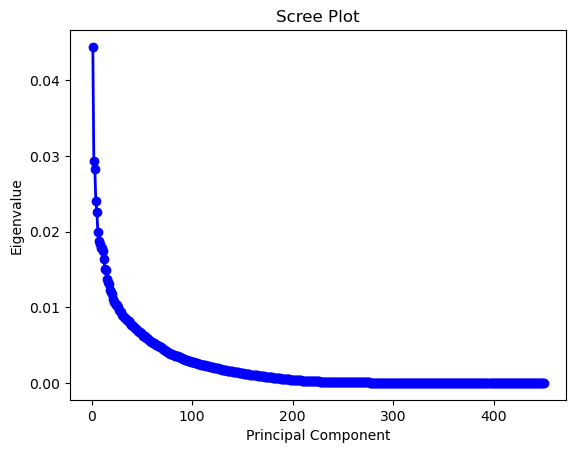

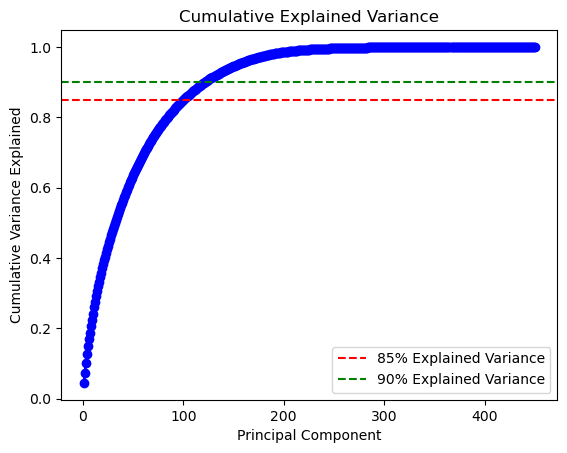

PCA - returning 61 componsnts to capture 70.0 % variation
SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_08', ('MICE Imputation', 'SMOTE balancing', 'PCA selection'), 'baseline RF classifier', 0.9209183673469388, 0.2727272727272727, 0.11538461538461539, 0.16216216216216217, array([[358,   8],
       [ 23,   3]], dtype=int64), 0.5467633459436738, array([0.        , 0.02185792, 1.        ]), array([0.        , 0.11538462, 1.        ]))


In [68]:
### Model 8 - "MICE Imputation"-"PCA reduction"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_08",
                ( "MICE Imputation", "SMOTE balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [80]:
# create a dataframe of model results.
model_results_df = pd.DataFrame(model_results_list,
                                columns = ['Model name',
                                           'CRISP DM Decisions',
                                           'Technique',
                                           'Accuracy',
                                           'Precision',
                                           'Recall',
                                           'F1',
                                           'Confusion Matrix',
                                           'ROC AUC',
                                           "TPR",
                                           "FPR"]
                                            )
# Display the results
model_results_df.head()

,Model name,CRISP DM Decisions,Technique,Accuracy,Precision,Recall,F1,Confusion Matrix,ROC AUC,TPR,FPR
0,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
1,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.926020,0.333333,0.115385,0.171429,"[[360, 6], [23, 3]]",0.549496,"[0.0, 0.01639344262295082, 1.0]","[0.0, 0.11538461538461539, 1.0]"
2,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
3,model_04,"(KNN Imputation, SMOTE balancing, PCA selection)",baseline RF classifier,0.920918,0.272727,0.115385,0.162162,"[[358, 8], [23, 3]]",0.546763,"[0.0, 0.02185792349726776, 1.0]","[0.0, 0.11538461538461539, 1.0]"
4,model_05,"(MICE Imputation, ADASYN balancing, BORUTA sel...",baseline RF classifier,0.877551,0.133333,0.153846,0.142857,"[[340, 26], [22, 4]]",0.541404,"[0.0, 0.07103825136612021, 1.0]","[0.0, 0.15384615384615385, 1.0]"


In [77]:
model_results_df.sort_values(by=["ROC AUC"],ascending=False)

,Model name,CRISP DM Decisions,Technique,Accuracy,Precision,Recall,F1,Confusion Matrix,ROC AUC,TPR,FPR
2,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
11,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
0,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
5,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
17,model_07,"(MICE Imputation, SMOTE balancing, BORUTA sele...",baseline RF classifier,0.900510,0.217391,0.192308,0.204082,"[[348, 18], [21, 5]]",0.571564,"[0.0, 0.04918032786885246, 1.0]","[0.0, 0.19230769230769232, 1.0]"
9,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.920918,0.307692,0.153846,0.205128,"[[357, 9], [22, 4]]",0.564628,"[0.0, 0.02459016393442623, 1.0]","[0.0, 0.15384615384615385, 1.0]"
7,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.918367,0.285714,0.153846,0.200000,"[[356, 10], [22, 4]]",0.563262,"[0.0, 0.0273224043715847, 1.0]","[0.0, 0.15384615384615385, 1.0]"
12,model_04,"(KNN Imputation, SMOTE balancing, PCA selection)",baseline RF classifier,0.913265,0.250000,0.153846,0.190476,"[[354, 12], [22, 4]]",0.560530,"[0.0, 0.03278688524590164, 1.0]","[0.0, 0.15384615384615385, 1.0]"
8,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.908163,0.222222,0.153846,0.181818,"[[352, 14], [22, 4]]",0.557797,"[0.0, 0.03825136612021858, 1.0]","[0.0, 0.15384615384615385, 1.0]"
1,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.926020,0.333333,0.115385,0.171429,"[[360, 6], [23, 3]]",0.549496,"[0.0, 0.01639344262295082, 1.0]","[0.0, 0.11538461538461539, 1.0]"


In [ ]:
# print_confusion_matrix for all the models

num_models = model_results_df.shape[0]
fig,axs = plt.subplots(figsize = (8,num_models * 5), nrows=num_models)
for ind,row in model_results_df.iterrows():
  model_name = row['Model name'].replace("model","Mod")
  cm = row['Confusion Matrix']
  ConfusionMatrixDisplay(cm,display_labels=[model_name + ' -1', model_name + '  1']).plot(ax = axs[ind])
plt.show()

In [72]:
## display relevant variables form the table
model_results_df[['CRISP DM Decisions', 'Accuracy','Precision', 'Recall','F1','ROC AUC']].sort_values(by='ROC AUC',ascending=False)


,CRISP DM Decisions,Accuracy,Precision,Recall,F1,ROC AUC
2,"(KNN Imputation, SMOTE balancing, BORUTA selec...",0.892857,0.250000,0.307692,0.275862,0.621059
11,"(KNN Imputation, SMOTE balancing, BORUTA selec...",0.892857,0.250000,0.307692,0.275862,0.621059
0,"(KNN Imputation, ADASYN balancing, BORUTA sele...",0.875000,0.171429,0.230769,0.196721,0.575767
5,"(KNN Imputation, ADASYN balancing, BORUTA sele...",0.875000,0.171429,0.230769,0.196721,0.575767
17,"(MICE Imputation, SMOTE balancing, BORUTA sele...",0.900510,0.217391,0.192308,0.204082,0.571564
9,"(KNN Imputation, ADASYN balancing, PCA selection)",0.920918,0.307692,0.153846,0.205128,0.564628
7,"(KNN Imputation, ADASYN balancing, PCA selection)",0.918367,0.285714,0.153846,0.200000,0.563262
12,"(KNN Imputation, SMOTE balancing, PCA selection)",0.913265,0.250000,0.153846,0.190476,0.560530
8,"(KNN Imputation, ADASYN balancing, PCA selection)",0.908163,0.222222,0.153846,0.181818,0.557797
1,"(KNN Imputation, ADASYN balancing, PCA selection)",0.926020,0.333333,0.115385,0.171429,0.549496


In [73]:
#def calculate_error_cost(confusion_matrix, cost_type1=20, cost_type2=1): to be checked
    """
    Calculate the total error cost based on the confusion matrix.
    
    Parameters:
    confusion_matrix (array-like): Confusion matrix of the model.
    cost_type1 (float): Cost of Type I error (False Positive).
    cost_type2 (float): Cost of Type II error (False Negative).
    
    Returns:
    float: Total error cost.
    """
    TN, FP, FN, TP = confusion_matrix.ravel()
    type1_error_cost = FP * cost_type1
    type2_error_cost = FN * cost_type2
    total_error_cost = type1_error_cost + type2_error_cost
    return total_error_cost

In [ ]:
results_df = pd.DataFrame(model_results_list)
results_df.to_excel('model_results_with_loss.xlsx', index=False)